In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [ ]:
!pip install -q seaborn colorama tld plotly whois wordcloud gensim nltk tldextract hmmlearn xgboost lightgbm catboost

# *requirements*

In [ ]:
import nltk
import tldextract
import hashlib
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from urllib.parse import urlparse
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError
from nltk.tokenize import word_tokenize

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
urls_data = pd.read_csv('/content/drive/MyDrive/dataset.csv')
urls_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
urls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
urls_data['url'] = urls_data['url'].replace('www.', '', regex=True)

In [ ]:
urls_data["type"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
urls_data["url_type"] = urls_data["type"].replace({'benign':1, 'defacement':2, 'phishing':3, 'malware':4 })
class_labels = {1: "benign", 2: "defacement", 3: "phishing", 4: "malware"}

# *Pre-Process the data*

In [ ]:
def get_url_length(url):
    return len(url)

def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits

def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars

def has_shortening_service(url):
    pattern = re.compile(r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                         r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                         r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                         r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                         r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                         r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                         r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                         r'tr\.im|link\.zip\.net')
    match = pattern.search(url)
    return int(bool(match))

def abnormal_url(url):
    parsed_url = urlparse(url)
    hostname = parsed_url.hostname
    if hostname:
        hostname = str(hostname)
        match = re.search(hostname, url)
        if match:
            return 1
    return 0

def secure_http(url):
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 1
    else:
        return 0

def have_ip_address(url):
    pattern = r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.' \
              r'([01]?\d\d?|2[0-4]\d|25[0-5])\/)|' \
              r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' \
              r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|' \
              r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)|' \
              r'((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)'

    match = re.search(pattern, url)
    if match:
        return 1
    else:
        return 0

def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
urls_data['pri_domain'] = urls_data['url'].apply(lambda x: extract_pri_domain(x))
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))
urls_data['letters_count'] =urls_data['url'].apply(lambda x: count_letters(x))
urls_data['digits_count']  =urls_data['url'].apply(lambda x: count_digits(x))
urls_data['special_chars_count']  =urls_data['url'].apply(lambda x: count_special_chars(x))
urls_data['shortened']  =urls_data['url'].apply(lambda x: has_shortening_service(x))
urls_data['secure_http']  =urls_data['url'].apply(lambda x: secure_http(x))
urls_data['abnormal_url']  =urls_data['url'].apply(lambda x: abnormal_url(x))
urls_data['have_ip']  =urls_data['url'].apply(lambda x: have_ip_address(x))

In [ ]:
urls_data.head()

,url,type,url_type,pri_domain,url_len,letters_count,digits_count,special_chars_count,shortened,secure_http,abnormal_url,have_ip
0,br-icloud.com.br,phishing,3,br-icloud.com.br,16,13,0,3,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,1,mp3raid.com,35,29,1,5,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,1,bopsecrets.org,31,25,1,5,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,2,garage-pirenne.be,84,60,7,17,0,0,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2,adventure-nicaragua.net,235,199,22,14,0,0,1,0


In [ ]:
urls_data.fillna(0,inplace=True)

In [ ]:
urls_data.isnull().sum()

url                    0
type                   0
url_type               0
pri_domain             0
url_len                0
letters_count          0
digits_count           0
special_chars_count    0
shortened              0
secure_http            0
abnormal_url           0
have_ip                0
dtype: int64

In [ ]:
ccTLD_to_region = {".ac": "Ascension Island", ".ad": "Andorra", ".ae": "United Arab Emirates", ".af": "Afghanistan", ".ag": "Antigua and Barbuda", ".ai": "Anguilla", ".al": "Albania", ".am": "Armenia", ".an": "Netherlands Antilles", ".ao": "Angola", ".aq": "Antarctica", ".ar": "Argentina", ".as": "American Samoa", ".at": "Austria", ".au": "Australia", ".aw": "Aruba", ".ax": "Åland Islands", ".az": "Azerbaijan", ".ba": "Bosnia and Herzegovina", ".bb": "Barbados", ".bd": "Bangladesh", ".be": "Belgium", ".bf": "Burkina Faso", ".bg": "Bulgaria", ".bh": "Bahrain", ".bi": "Burundi", ".bj": "Benin", ".bm": "Bermuda", ".bn": "Brunei Darussalam", ".bo": "Bolivia", ".br": "Brazil", ".bs": "Bahamas", ".bt": "Bhutan", ".bv": "Bouvet Island", ".bw": "Botswana", ".by": "Belarus", ".bz": "Belize", ".ca": "Canada", ".cc": "Cocos Islands", ".cd": "Democratic Republic of the Congo", ".cf": "Central African Republic", ".cg": "Republic of the Congo", ".ch": "Switzerland", ".ci": "Côte d'Ivoire", ".ck": "Cook Islands", ".cl": "Chile", ".cm": "Cameroon", ".cn": "China", ".co": "Colombia", ".cr": "Costa Rica", ".cu": "Cuba", ".cv": "Cape Verde", ".cw": "Curaçao", ".cx": "Christmas Island", ".cy": "Cyprus", ".cz": "Czech Republic", ".de": "Germany", ".dj": "Djibouti", ".dk": "Denmark", ".dm": "Dominica", ".do": "Dominican Republic", ".dz": "Algeria", ".ec": "Ecuador", ".ee": "Estonia", ".eg": "Egypt", ".er": "Eritrea", ".es": "Spain", ".et": "Ethiopia", ".eu": "European Union", ".fi": "Finland", ".fj": "Fiji", ".fk": "Falkland Islands", ".fm": "Federated States of Micronesia", ".fo": "Faroe Islands", ".fr": "France", ".ga": "Gabon", ".gb": "United Kingdom", ".gd": "Grenada", ".ge": "Georgia", ".gf": "French Guiana", ".gg": "Guernsey", ".gh": "Ghana", ".gi": "Gibraltar", ".gl": "Greenland", ".gm": "Gambia", ".gn": "Guinea", ".gp": "Guadeloupe", ".gq": "Equatorial Guinea", ".gr": "Greece", ".gs": "South Georgia and the South Sandwich Islands", ".gt": "Guatemala", ".gu": "Guam", ".gw": "Guinea-Bissau", ".gy": "Guyana", ".hk": "Hong Kong", ".hm": "Heard Island and McDonald Islands", ".hn": "Honduras", ".hr": "Croatia", ".ht": "Haiti", ".hu": "Hungary", ".id": "Indonesia", ".ie": "Ireland", ".il": "Israel", ".im": "Isle of Man", ".in": "India", ".io": "British Indian Ocean Territory", ".iq": "Iraq", ".ir": "Iran", ".is": "Iceland", ".it": "Italy", ".je": "Jersey", ".jm": "Jamaica", ".jo": "Jordan", ".jp": "Japan", ".ke": "Kenya", ".kg": "Kyrgyzstan", ".kh": "Cambodia", ".ki": "Kiribati", ".km": "Comoros", ".kn": "Saint Kitts and Nevis", ".kp": "Democratic People's Republic of Korea (North Korea)", ".kr": "Republic of Korea (South Korea)", ".kw": "Kuwait", ".ky": "Cayman Islands", ".kz": "Kazakhstan", ".la": "Laos", ".lb": "Lebanon", ".lc": "Saint Lucia", ".li": "Liechtenstein", ".lk": "Sri Lanka", ".lr": "Liberia", ".ls": "Lesotho", ".lt": "Lithuania", ".lu": "Luxembourg", ".lv": "Latvia", ".ly": "Libya", ".ma": "Morocco", ".mc": "Monaco", ".md": "Moldova", ".me": "Montenegro", ".mf": "Saint Martin (French part)", ".mg": "Madagascar", ".mh": "Marshall Islands", ".mk": "North Macedonia", ".ml": "Mali", ".mm": "Myanmar", ".mn": "Mongolia", ".mo": "Macao", ".mp": "Northern Mariana Islands", ".mq": "Martinique", ".mr": "Mauritania", ".ms": "Montserrat", ".mt": "Malta", ".mu": "Mauritius", ".mv": "Maldives", ".mw": "Malawi", ".mx": "Mexico", ".my": "Malaysia", ".mz": "Mozambique", ".na": "Namibia", ".nc": "New Caledonia", ".ne": "Niger", ".nf": "Norfolk Island", ".ng": "Nigeria", ".ni": "Nicaragua", ".nl": "Netherlands", ".no": "Norway", ".np": "Nepal", ".nr": "Nauru", ".nu": "Niue", ".nz": "New Zealand", ".om": "Oman", ".pa": "Panama", ".pe": "Peru", ".pf": "French Polynesia", ".pg": "Papua New Guinea", ".ph": "Philippines", ".pk": "Pakistan", ".pl": "Poland", ".pm": "Saint Pierre and Miquelon", ".pn": "Pitcairn", ".pr": "Puerto Rico", ".ps": "Palestinian Territory", ".pt": "Portugal", ".pw": "Palau", ".py": "Paraguay", ".qa": "Qatar", ".re": "Réunion", ".ro": "Romania", ".rs": "Serbia", ".ru": "Russia", ".rw": "Rwanda", ".sa": "Saudi Arabia", ".sb": "Solomon Islands", ".sc": "Seychelles", ".sd": "Sudan", ".se": "Sweden", ".sg": "Singapore", ".sh": "Saint Helena", ".si": "Slovenia", ".sj": "Svalbard and Jan Mayen", ".sk": "Slovakia", ".sl": "Sierra Leone", ".sm": "San Marino", ".sn": "Senegal", ".so": "Somalia", ".sr": "Suriname", ".ss": "South Sudan", ".st": "São Tomé and Príncipe", ".sv": "El Salvador", ".sx": "Sint Maarten (Dutch part)", ".sy": "Syria", ".sz": "Eswatini", ".tc": "Turks and Caicos Islands", ".td": "Chad", ".tf": "French Southern Territories", ".tg": "Togo", ".th": "Thailand", ".tj": "Tajikistan", ".tk": "Tokelau", ".tl": "Timor-Leste", ".tm": "Turkmenistan", ".tn": "Tunisia", ".to": "Tonga", ".tr": "Turkey", ".tt": "Trinidad and Tobago", ".tv": "Tuvalu", ".tw": "Taiwan", ".tz": "Tanzania", ".ua": "Ukraine", ".ug": "Uganda", ".uk": "United Kingdom", ".us": "United States", ".uy": "Uruguay", ".uz": "Uzbekistan", ".va": "Vatican City", ".vc": "Saint Vincent and the Grenadines", ".ve": "Venezuela", ".vg": "British Virgin Islands", ".vi": "U.S. Virgin Islands", ".vn": "Vietnam", ".vu": "Vanuatu", ".wf": "Wallis and Futuna", ".ws": "Samoa", ".ye": "Yemen", ".yt": "Mayotte", ".za": "South Africa", ".zm": "Zambia", ".zw": "Zimbabwe"}

In [ ]:
len(ccTLD_to_region)

249

In [ ]:
def get_url_region(primary_domain):
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]

    return "Global"

def extract_root_domain(url):
    extracted = tldextract.extract(url)
    root_domain = extracted.domain
    return root_domain

In [ ]:
urls_data['url_region'] = urls_data['pri_domain'].apply(lambda x: get_url_region(str(x)))
urls_data['root_domain'] = urls_data['pri_domain'].apply(lambda x: extract_root_domain(str(x)))

In [ ]:
from wordcloud import WordCloud

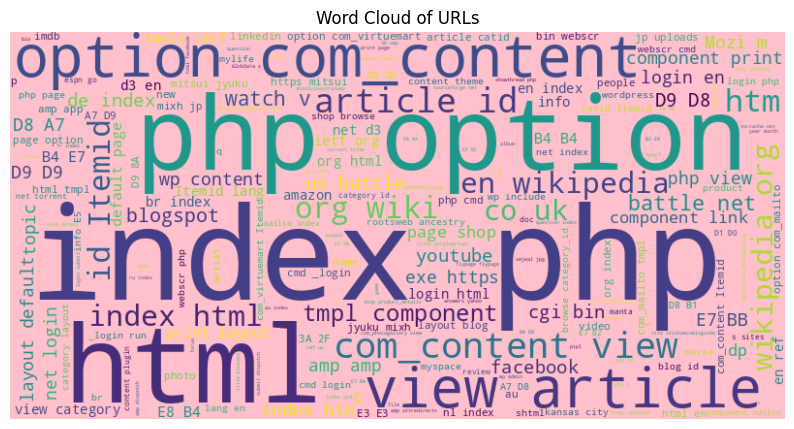

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='pink').generate(' '.join(urls_data['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [ ]:
urls_data.columns

Index(['url', 'type', 'url_type', 'pri_domain', 'url_len', 'letters_count',
       'digits_count', 'special_chars_count', 'shortened', 'secure_http',
       'abnormal_url', 'have_ip', 'url_region', 'root_domain'],
      dtype='object')

In [ ]:
urls_data.drop_duplicates(inplace=True)

In [ ]:
urls_data['root_domain'].value_counts()

wikipedia                  13426
0                          12224
youtube                     8639
blogspot                    8468
facebook                    8362
                           ...  
slipcue                        1
alsholm                        1
internetdownloadmanager        1
jvdgrocerystore                1
xboxaddict                     1
Name: root_domain, Length: 147573, dtype: int64

In [ ]:
urls_data = urls_data[urls_data['root_domain'] != '0']

In [ ]:
def hash_encode(category):
    hash_object = hashlib.md5(category.encode())
    return int(hash_object.hexdigest(), 16) % (10 ** 8)

In [ ]:
# Apply hash encoding to the categorical feature
urls_data['root_domain'] = urls_data['root_domain'].apply(hash_encode)

# Apply hash encoding to the categorical feature
urls_data['url_region'] = urls_data['url_region'].apply(hash_encode)

In [ ]:
urls_data.head()

,url,type,url_type,pri_domain,url_len,letters_count,digits_count,special_chars_count,shortened,secure_http,abnormal_url,have_ip,url_region,root_domain
0,br-icloud.com.br,phishing,3,br-icloud.com.br,16,13,0,3,0,0,0,0,27739261,1310791
1,mp3raid.com/music/krizz_kaliko.html,benign,1,mp3raid.com,35,29,1,5,0,0,0,0,32604616,58335668
2,bopsecrets.org/rexroth/cr/1.htm,benign,1,bopsecrets.org,31,25,1,5,0,0,0,0,32604616,28611805
3,http://garage-pirenne.be/index.php?option=com_...,defacement,2,garage-pirenne.be,84,60,7,17,0,0,1,0,71484583,89045308
4,http://adventure-nicaragua.net/index.php?optio...,defacement,2,adventure-nicaragua.net,235,199,22,14,0,0,1,0,32604616,76838614


In [ ]:
urls_data.shape

(627886, 14)

# *Training and Testing datas*

In [ ]:
data = urls_data.drop(columns=['url','type','pri_domain'])
data_input = data.drop(columns=['url_type'])
data_output = data['url_type']
training_input,testing_input,training_output,testing_output = train_test_split(data_input,data_output,test_size=0.3, random_state=42)

In [ ]:
print(f"training_input Shape : {training_input.shape}")
print(f"training_output Shape : {training_output.shape}")
print(f"testing_input Shape : {testing_input.shape}")
print(f"testing_output Shape : {testing_output.shape}")

training_input Shape : (439520, 10)
training_output Shape : (439520,)
testing_input Shape : (188366, 10)
testing_output Shape : (188366,)


In [ ]:
from sklearn.pipeline import Pipeline

# *Test it on different base_models*


In [ ]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    KNeighborsClassifier(),
]

In [ ]:
results = []
for classifier in classifiers:
    # Create a pipeline with the scaler and classifier
    pipeline = Pipeline([
        ('classifier', classifier)
    ])
    # Perform cross-validation using the pipeline
    scores = cross_val_score(pipeline, data_input, data_output, cv=2, scoring='accuracy')

    # Calculate additional evaluation metrics
    y_pred = cross_val_predict(pipeline, data_input, data_output, cv=2)
    accuracy = accuracy_score(data_output, y_pred)
    recall = recall_score(data_output, y_pred, average='weighted')
    precision = precision_score(data_output, y_pred, average='weighted', zero_division=1)  # Set zero_division=1
    f1 = f1_score(data_output, y_pred, average='weighted')
    # Append the results to the list
    results.append((classifier.__class__.__name__, accuracy, recall, precision, f1))

In [ ]:
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Recall', 'Precision', 'F1-Score'])
results = results.sort_values(by='Accuracy', ascending=False)
results.head()

,Classifier,Accuracy,Recall,Precision,F1-Score
0,RandomForestClassifier,0.805673,0.805673,0.733916,0.763211
2,KNeighborsClassifier,0.785095,0.785095,0.740452,0.756078
1,GaussianNB,0.677277,0.677277,0.711980,0.600037


# ***Training the best base_model***

In [ ]:
training_model = RandomForestClassifier()
training_model.fit(training_input, training_output)

RandomForestClassifier()

In [ ]:
testing_prediction = training_model.predict(testing_input)

In [ ]:
# Replace numeric labels with string labels in y_test and y_pred
testing_output = [class_labels[label] for label in testing_output]
testing_prediction = [class_labels[label] for label in testing_prediction]

print(classification_report(testing_output,testing_prediction))

              precision    recall  f1-score   support

      benign       0.93      0.95      0.94    128308
  defacement       0.92      0.96      0.94     28491
     malware       0.88      0.74      0.81      3509
    phishing       0.70      0.61      0.65     28058

    accuracy                           0.90    188366
   macro avg       0.86      0.82      0.83    188366
weighted avg       0.89      0.90      0.89    188366



# *Save the trained model*

In [ ]:
import joblib
import os

# Save the trained model to a file
model_filename = "trained_model.pkl"
model_file_path = os.path.join("/content/drive/MyDrive", model_filename)
joblib.dump(training_model, model_file_path)

print("Model saved to Google Drive:", model_file_path)

Model saved to Google Drive: /content/drive/MyDrive/trained_model.pkl


In [ ]:
# Create the Plotly figure
fig = go.Figure(data=go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                fill_color='black',
                font=dict(color='white'),
                align='center'),
    cells=dict(values=[results['Classifier'], results['Accuracy'], results['Precision'],
                       results['Recall'], results['F1-Score']],
               fill_color='black',
               font=dict(color='white'),
               align='center')))

# Update layout for dark background and white font
fig.update_layout(
    paper_bgcolor='beige',
    plot_bgcolor='lightblue',
    font=dict(color='black'))

# Display the plot
fig.show()

In [ ]:
count = urls_data['type'].value_counts()

# Define a color scale for the bars
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])

# Update layout
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',  # Set plot background color to black
    paper_bgcolor='black',  # Set paper background color to black
    font=dict(color='white')  # Set font color to white
)

# Update x-axis tick font color
fig.update_xaxes(tickfont=dict(color='white'))

# Update y-axis tick font color
fig.update_yaxes(tickfont=dict(color='white'))

fig.show()